# Carbon System Example Code

**Author: Andrew Reed**

### Purpose
The purpose of this notebook is to provide an example of working with ```PHSEN``` data from the Ocean Observatories Initiative. Example datasets are provided in the ```data``` directory. This code is meant to highlight necessary post-download processing steps to improve data quality and useability.

### Data
This notebook makes use of the PHSEN dataset from the Global Irminger Array Flanking Mooring A (GI03FLMA). This instrument is located at a latitude, longitude of 59.77095, -39.88360 in the Irminger Sea, approximately XXX miles southeast of Greenland.

The example ```PCO2A``` datasets were downloaded as netCDF files from the Ocean Observatories Initiative data portal for all available, reformatted to clean up the dimensions, and then merged into one dataset. This process is outlined in the notebook **OOI - Data Downloading and Cleaning**. 

The discrete bottle data were downloaded from the OOI Alfresco Document Server at https://alfresco.oceanobservatories.org. The relevant files are in OOI > Global Irminger Sea Array > Cruise Data > "Cruise Directory" > Ship Data > Water Sampling > "Discrete Summary Sample Sheet.xlsx". For more information and an example of working with and validating discrete sample data please follow the **OOI - Discrete Bottle Data** example notebook. 

### Dependencies & Use
This notebook and related examples are all done using the Python programming language. Additionally, it relies on several github repositories and existing code bases for working with OOI data. The first is the OOINet repository at https://github.com/reedan88/OOINet. This repo hosts modules and tools that are designed to assist in requesting, importing, and downloading data from the Ocean Observatories Initiative API by M2M requests. It also utilizes code from the OOI Data Explorations repo at https://github.com/oceanobservatories/ooi-data-explorations. This repository contains modules, tools, and notebooks that also assist with downloading data from the OOI API, as well as extensive tools for processing the downloaded datasets to make them more user-friendly. Lastly, functions written specifically for this example notebook are stored in the utils.py module in the parent directory, allowing for direct imports.

In [2]:
# Import libraries
import os, sys, re
import yaml
import numpy as np
import pandas as pd
import xarray as xr
# Supress auto warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import the OOINet M2M tool
sys.path.append("/home/andrew/Documents/OOI-CGSN/ooinet/ooinet/")
from m2m import M2M

In [4]:
# Add plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sys.path.append("..")
from utils import *

#### Set OOINet API access
In order access and download data from OOINet, need to have an OOINet api username and access token. Those can be found on your profile after logging in to OOINet. Your username and access token should NOT be stored in this notebook/python script (for security). It should be stored in a yaml file, kept in the same directory, named user_info.yaml.

In [6]:
userinfo = yaml.load(open("../user_info.yaml"), Loader=yaml.SafeLoader)
username = userinfo["apiname"]
token = userinfo["apikey"]

#### Connect to OOINet

In [7]:
OOINet = M2M(username, token)

---
## Load the data

First, we want to load the data into the notebook. Below, I utilize ```xarray``` to open and work with the dataset. ```xarray``` is optimized for working with multidimensional data and is especially useful for datasets which may be bigger than available memory on the computer.

In [12]:
# Load the phsen dataset from the local directory, using "chunks" to keep the data in optimized dask arrays
pco2a = xr.open_dataset("../data/GI01SUMO-SBD12-04-PCO2AA000_combined.nc", chunks="auto")

# For convience, also set the reference designator name
refdes = "GI01SUMO-SBD12-04-PCO2AA000"

Look at the structure of the ```PCO2A``` dataset:

In [13]:
pco2a

<xarray.Dataset>
Dimensions:                               (time: 234083)
Coordinates:
  * time                                  (time) datetime64[ns] 2014-09-10T19...
Data variables: (12/30)
    air_temperature                       (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    avg_irga_temperature                  (time) float32 dask.array<chunksize=(234083,), meta=np.ndarray>
    barometric_pressure                   (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    current_a2d                           (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    deployment                            (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    gas_stream_pressure                   (time) float32 dask.array<chunksize=(234083,), meta=np.ndarray>
    ...                                    ...
    precipitation                         (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    relative_humidity                     (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    sea_surface_temperature               (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    shortwave_irradiance                  (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
    supply_voltage                        (time) float32 dask.array<chunksize=(234083,), meta=np.ndarray>
    zero_a2d                              (time) float64 dask.array<chunksize=(234083,), meta=np.ndarray>
Attributes: (12/70)
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             pco2a_a_dcl_instrument_water
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.9337
    lon:                                -39.47378
    Location_name:                      Global Irminger Sea Apex Surface Moor...

There are two data variables in which we are interested: ```partial_pressure_co2_ssw```, which is the pCO2 of surface water; and ```partial_pressure_co2_atm```, which is the pCO2 of the air. Other data variables we will be using are the ```deployment``` variable, which contains an entry for which deployment each timestamp corresponds to.

Now, plot the ```partial_pressure_co2_ssw``` data variable along with the relevant deployments to get an idea of when the instrument was changed.

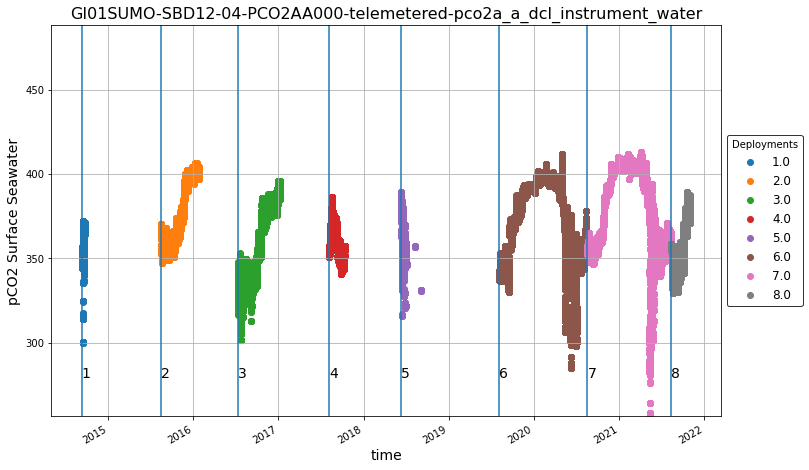

In [14]:
fig, ax = plot_variable(pco2a, "partial_pressure_co2_ssw")

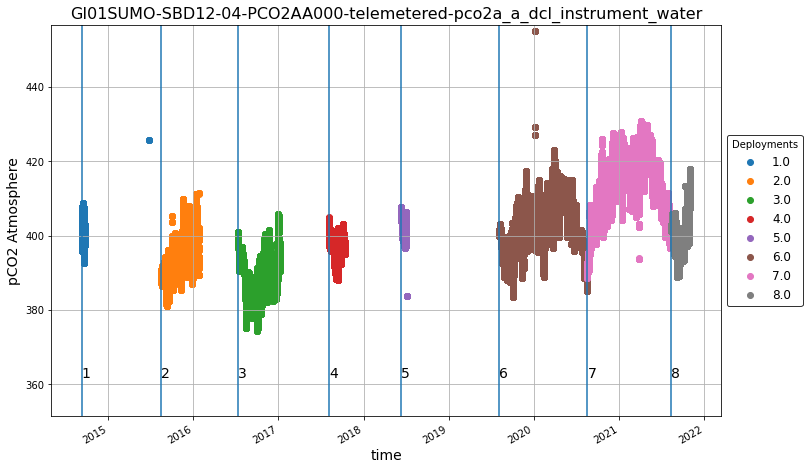

In [15]:
fig, ax = plot_variable(pco2a, "partial_pressure_co2_atm")

---
## Annotations

Since we are loading annotations which were previously downloaded and saved as a csv, we first need to do some parsing of the annotations to properly work with lists, etc. in the pandas dataframe.

In [19]:
annotations = load_annotations("../data/GI01SUMO-SBD12-04-PCO2AA000_annotations.csv")
annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,46,GI01SUMO,None,None,None,None,1423958400000,1.440202e+12,Deployment 1: Status data sent from the buoy i...,False,lgarzio@marine.rutgers.edu,0,[]
1,.AnnotationRecord,47,GI01SUMO,None,None,None,None,1453852800000,1.468886e+12,Deployment 2: A period of violent weather caus...,False,lgarzio@marine.rutgers.edu,0,[]
2,.AnnotationRecord,121,GI01SUMO,None,None,None,None,1482796800000,1.491523e+12,Deployment 3: Wind turbines were disabled due ...,False,lgarzio@marine.rutgers.edu,0,[]
3,.AnnotationRecord,686,GI01SUMO,SBD12,04-PCO2AA000,None,None,1410375000000,1.411572e+12,Deployment 1: The tubing to the pump was missi...,False,lgarzio@marine.rutgers.edu,0,[]
4,.AnnotationRecord,102,GI01SUMO,None,None,None,None,1501957020000,1.528963e+12,Deployment 4: at 10:03 UTC on 12 October 2017 ...,False,lgarzio@marine.rutgers.edu,0,[]
5,.AnnotationRecord,1743,GI01SUMO,None,None,telemetered,None,1571702400000,1.598438e+12,Deployment 6: *UPDATED 2020-04-27: As of 2020-...,False,cdobson@whoi.edu,0,[]
6,.AnnotationRecord,1481,GI01SUMO,SBD12,04-PCO2AA000,None,None,1530741480000,1.565338e+12,Deployment 5: Instrument stopped sending valid...,False,lgarzio@marine.rutgers.edu,9,[]
7,.AnnotationRecord,1625,GI01SUMO,None,None,None,None,1560988800000,1.565338e+12,Deployment 5: Battery voltage dropped below 24...,False,cdobson@whoi.edu,0,[]
8,.AnnotationRecord,2255,GI01SUMO,SBD12,None,None,None,1593648000000,1.595290e+12,Deployment 6: Due to power generation concerns...,False,cdobson@whoi.edu,0,[]
9,.AnnotationRecord,3328,GI01SUMO,SBD12,None,None,None,1635957000000,NaN,Deployment 8: DCL12 power was disabled 11/3/20...,False,cdobson@whoi.edu,9,[]


In [21]:
annotations.loc[5, "annotation"]

'Deployment 6: *UPDATED 2020-04-27: As of 2020-02-21 data for most instruments are being telemetered again (via Iridium). A gap in telemetered data is expected between 2019-10-22 and 2020-02-21 and will not be backfilled but these data will be available upon recovery.*Both fleet broadband units have failed and no more telemetered data is expected at this time. Instruments are believed to be operating as normal and their data will be available upon recovery. '

In [22]:
# Add in the annotation qc flags
pco2a = OOINet.add_annotation_qc_flag(pco2a, annotations)

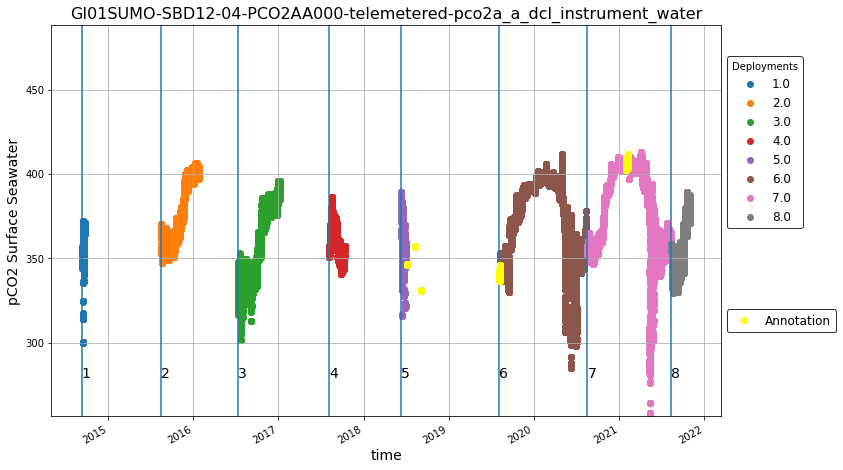

In [24]:
# Plot figure which highlights data points with a corresponding annotation
fig, ax = plot_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(pco2a.time.where(pco2a.rollup_annotations_qc_results == 9), 
             pco2a.partial_pressure_co2_ssw.where(pco2a.rollup_annotations_qc_results == 9), 
             marker="o", linestyle="", color="yellow", label="Annotation")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


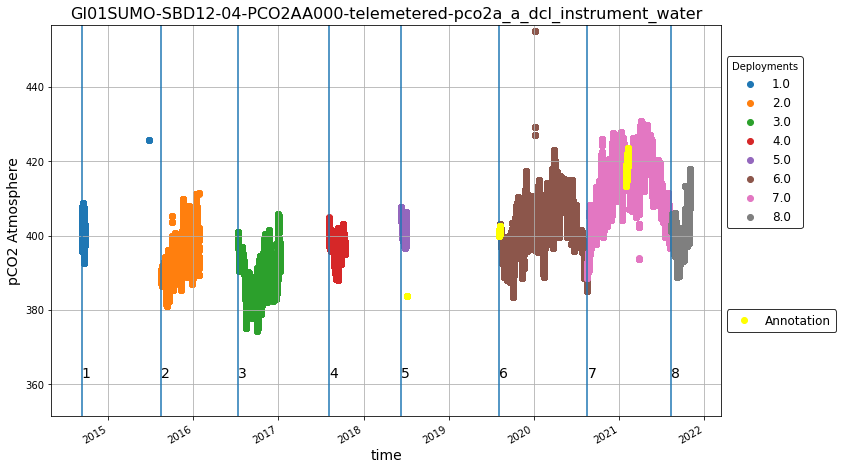

In [25]:
fig, ax = plot_variable(pco2a, "partial_pressure_co2_atm")
ax.set_alpha(0.7)
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(pco2a.time.where(pco2a.rollup_annotations_qc_results == 9), 
             pco2a.partial_pressure_co2_atm.where(pco2a.rollup_annotations_qc_results == 9), 
             marker="o", linestyle="", color="yellow", label="Annotation")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


---
## Bottle Data

The next step is to start comparing the PCO2A-measured seawater pCO2 against the pCO2 calculated from the measured DIC and TA. We start by loading all of the availabe Global Irminger Sea Array > Discrete Sample Summary sheets into a pandas dataframe. 

Once the bottle data is loaded, we need to do some processing to make the data easier to work with in python with pandas. The processing steps we'll take include:
1. Replacing fill values with NaNs
2. Parsing and converting timestamps
3. Replacing odd/unexpected values
4. Interpreting the quality flags to correspond to QARTOD QC standards
5. Filtering out bad data

In [28]:
from bottle_utils import *

In [29]:
bottle_dir = "../data/bottle_data/"
bottle_data = pd.DataFrame()
for file in os.listdir(bottle_dir):
    bottle_data = bottle_data.append(pd.read_excel(bottle_dir + file), ignore_index=True)

Replace the fill value of ```-9999999``` with NaNs:

In [30]:
bottle_data = bottle_data.replace(to_replace="-9999999", value=np.nan)
bottle_data = bottle_data.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects and remove the timezone:

In [31]:
bottle_data["Start Time [UTC]"] = bottle_data["Start Time [UTC]"].apply(lambda x: convert_times(x))
bottle_data["CTD Bottle Closure Time [UTC]"] = bottle_data["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

Convert any values with a "<", which indicates a value not statistically significant from zero, with zero:

In [32]:
bottle_data = bottle_data.applymap(not_statistically_sigificant)

#### Filter data
Next, we want to filter the data based on the data flag associated with the sample. First, we should drop all of the ```NaN``` values in the Niskin column to eliminate entries without any bottle samples. While these CTD casts may be of interest, the bottle data does not have the relevant data.

In [33]:
# Deployment
for col in bottle_data.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

In [34]:
bottle_data.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Discrete pH Replicate Flag,Calculated Alkalinity [umol/kg],Calculated DIC [umol/kg],Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A
0,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AR30-03,1,Release Test,62.7715,-28.656667,2018-06-06 08:16:04+00:00,1,*0000000000000100,1858.0,D:\Data\ar30-03001.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### Calculate Carbon System Parameters
---
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. I calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

In [35]:
# Calculate the Carbon System Parameters
from PyCO2SYS import CO2SYS

---
### Calculate Physical Properties
With the bottle samples cleaned up, we next want to calculate the conservative seawater properties, such as density, conservative temperature, absolute salinity, etc., using the updated TEOS properties with the ```gsw``` package.

In [36]:
import gsw

In [37]:
# ======================================================================
# Deployment: Calculate some key physical parameters to get density based on TEOS-10
SP = bottle_data[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1)
T = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
P = bottle_data["CTD Pressure [db]"]
LAT = bottle_data["CTD Latitude [deg]"]
LON = bottle_data["CTD Longitude [deg]"]

# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
bottle_data["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
bottle_data["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
bottle_data["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
bottle_data["CTD Sigma [kg/m^3]"] = RHO

del SP, T, P, LAT, LON, SA, CT, RHO, SIGMA0

---
### Calculate Carbon System Parameters
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. We can calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

Use of ```CO2SYS``` requires, at a minimum, the following inputs:
* ```PAR1```: First measured carbon system measurement
* ```PAR2```: Second measured carbon system measurement
* ```PAR1_type```: The type of PAR1 
        * 1 = Total Alkalinity umol/kg
        * 2 = DIC umol/kg
        * 3 = pH Total Scale
        * 4 = pCO2
        * 5 = fCO2
* ```PAR2_type```: The type of PAR2

The following are optional hydrographic inputs:
* ```salinity```: practical salinity
* ```temperature```: the temperature at which PAR1 and PAR2 are provided (in C)
* ```pressure```: the water pressure at which ```PAR1``` and ```PAR2``` are measured


In [38]:
PAR1 = bottle_data['Discrete Alkalinity [umol/kg]']
PAR2 = bottle_data['Discrete DIC [umol/kg]']
PAR1TYPE = 1
PAR2TYPE = 2
SAL = bottle_data['Discrete Salinity [psu]']
TEMPIN = 25
TEMPOUT = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
PRESIN = 0
PRESOUT = bottle_data['CTD Pressure [db]']
SI = bottle_data['Discrete Silicate [uM]'].fillna(value=0)
PO4 = bottle_data['Discrete Phosphate [uM]'].fillna(value=0)
PHSCALEIN = 1
K1K2CONSTANTS = 1
K2SO4CONSTANTS = 1

With the relevant parameters declared, pass the values into ```CO2SYS``` and get out the calculated values:

In [39]:
CO2dict = CO2SYS(PAR1, PAR2, PAR1TYPE, PAR2TYPE, SAL, TEMPIN, TEMPOUT, PRESIN, PRESOUT, SI, PO4, PHSCALEIN, K1K2CONSTANTS, K2SO4CONSTANTS)

Now add the calculated carbon system parameters to the cruise info:

In [40]:
bottle_data['Calculated Alkalinity [umol/kg]'] = CO2dict['TAlk']
bottle_data['Calculated CO2aq [umol/kg]'] = CO2dict['CO2out']
bottle_data['Calculated CO3 [umol/kg]'] = CO2dict['CO3out']
bottle_data['Calculated DIC [umol/kg]'] = CO2dict['TCO2']
bottle_data['Calculated pCO2 [uatm]'] = CO2dict['pCO2out']
bottle_data['Calculated pCO2in'] = CO2dict['pCO2in']
bottle_data['Calculated pH'] = CO2dict['pHoutTOTAL']

#### Compare Bottle and PCO2A Data

With the Discrete Bottle pH now adjusted for temperature and pressure to match in-situ conditions, we can begin to compare the Bottle pH with the PHSEN-measured pH. First, we need to identify which bottle measurements occurred where the PHSEN instrument is located.

Helpfully, the PHSEN datasets returned from OOI contain the latitude and longitude of the buoy where it was deployed. Additionally, we can get the **```Deployment```** information for the PHSEN reference designator, which includes the deployed depth. Using those two pieces of info, we can search the bottle data for measurements which occured within some set distance and depth of the PHSEN. 

For the Global Irminger Sea Array, a fairly relaxed maximum distance can be used, due to larger horizontal scales of variability. In comparison, observations at the Coastal Arrays - Pioneer and Endurace - should utilize smaller maximum distances.